In [ ]:
# Run this cell to install dependencies
!pip install torch torchvision timm transformers ftfy regex tqdm scikit-image --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
import timm
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define your path
base_dir = '/content/drive/MyDrive/Comparison with SOTA'
studies = ['Ours', 'Beliy et al', 'Ferrante et al', 'Gaziv et al', 'Mozafari et al', 'Ozcelik et al', 'Ren et al', 'Shen et al']
gt_dir = os.path.join(base_dir, 'Ground Truth')

Mounted at /content/drive


In [ ]:
# CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval().cuda()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# InceptionV3
inception = models.inception_v3(pretrained=True, transform_input=False).eval().cuda()
inception.fc = torch.nn.Identity()  # remove classification layer

# SwAV
swav = timm.create_model("resnet50", pretrained=True).eval().cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 99.3MB/s]


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
def load_image(path, size=(224, 224)):
    image = Image.open(path).convert("RGB").resize(size)
    return image

def image_to_tensor(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0).cuda()

def get_embedding_clip(image):
    inputs = clip_processor(images=image, return_tensors="pt").to('cuda')
    outputs = clip_model.get_image_features(**inputs)
    return outputs / outputs.norm(dim=-1, keepdim=True)

def get_embedding(model, image_tensor):
    with torch.no_grad():
        return model(image_tensor).cpu().numpy().flatten()

def compute_clipdist(a, b):
    return 1 - torch.nn.functional.cosine_similarity(a, b).item()

def compute_all_metrics(gt_img, rec_img):
    # SSIM
    ssim_val = ssim(np.array(gt_img.resize((224,224))), np.array(rec_img.resize((224,224))), channel_axis=-1)

    # Embeddings
    gt_tensor = image_to_tensor(gt_img)
    rec_tensor = image_to_tensor(rec_img)

    gt_clip = get_embedding_clip(gt_img)
    rec_clip = get_embedding_clip(rec_img)
    clip_dist = compute_clipdist(gt_clip, rec_clip)

    inc_dist = np.linalg.norm(get_embedding(inception, gt_tensor) - get_embedding(inception, rec_tensor))
    swav_dist = np.linalg.norm(get_embedding(swav, gt_tensor) - get_embedding(swav, rec_tensor))

    return ssim_val, clip_dist, inc_dist, swav_dist

In [ ]:
results = []

gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])

for fname in tqdm(gt_files):
    gt_path = os.path.join(gt_dir, fname)
    gt_img = load_image(gt_path)

    row = {'Image': fname}

    for study in studies:
        study_path = os.path.join(base_dir, study)
        suffix = '_generated_clip.png' if study == 'Ours' else f'_{study.replace(" ", "_")}.png'
        rec_name = fname.replace('_ground_truth.png', suffix)

        rec_path = os.path.join(study_path, rec_name)

        if not os.path.exists(rec_path):
            row[f'{study}_SSIM'] = row[f'{study}_CLIPDist'] = row[f'{study}_InceptionDist'] = row[f'{study}_SwAVDist'] = 'N/A'
            continue

        rec_img = load_image(rec_path)

        ssim_val, clip_dist, inc_dist, swav_dist = compute_all_metrics(gt_img, rec_img)

        row[f'{study}_SSIM'] = ssim_val
        row[f'{study}_CLIPDist'] = clip_dist
        row[f'{study}_InceptionDist'] = inc_dist
        row[f'{study}_SwAVDist'] = swav_dist

    results.append(row)

df = pd.DataFrame(results)
df.to_csv('/content/Quantitative_Comparison.csv', index=False)


  0%|          | 0/5 [00:00<?, ?it/s]

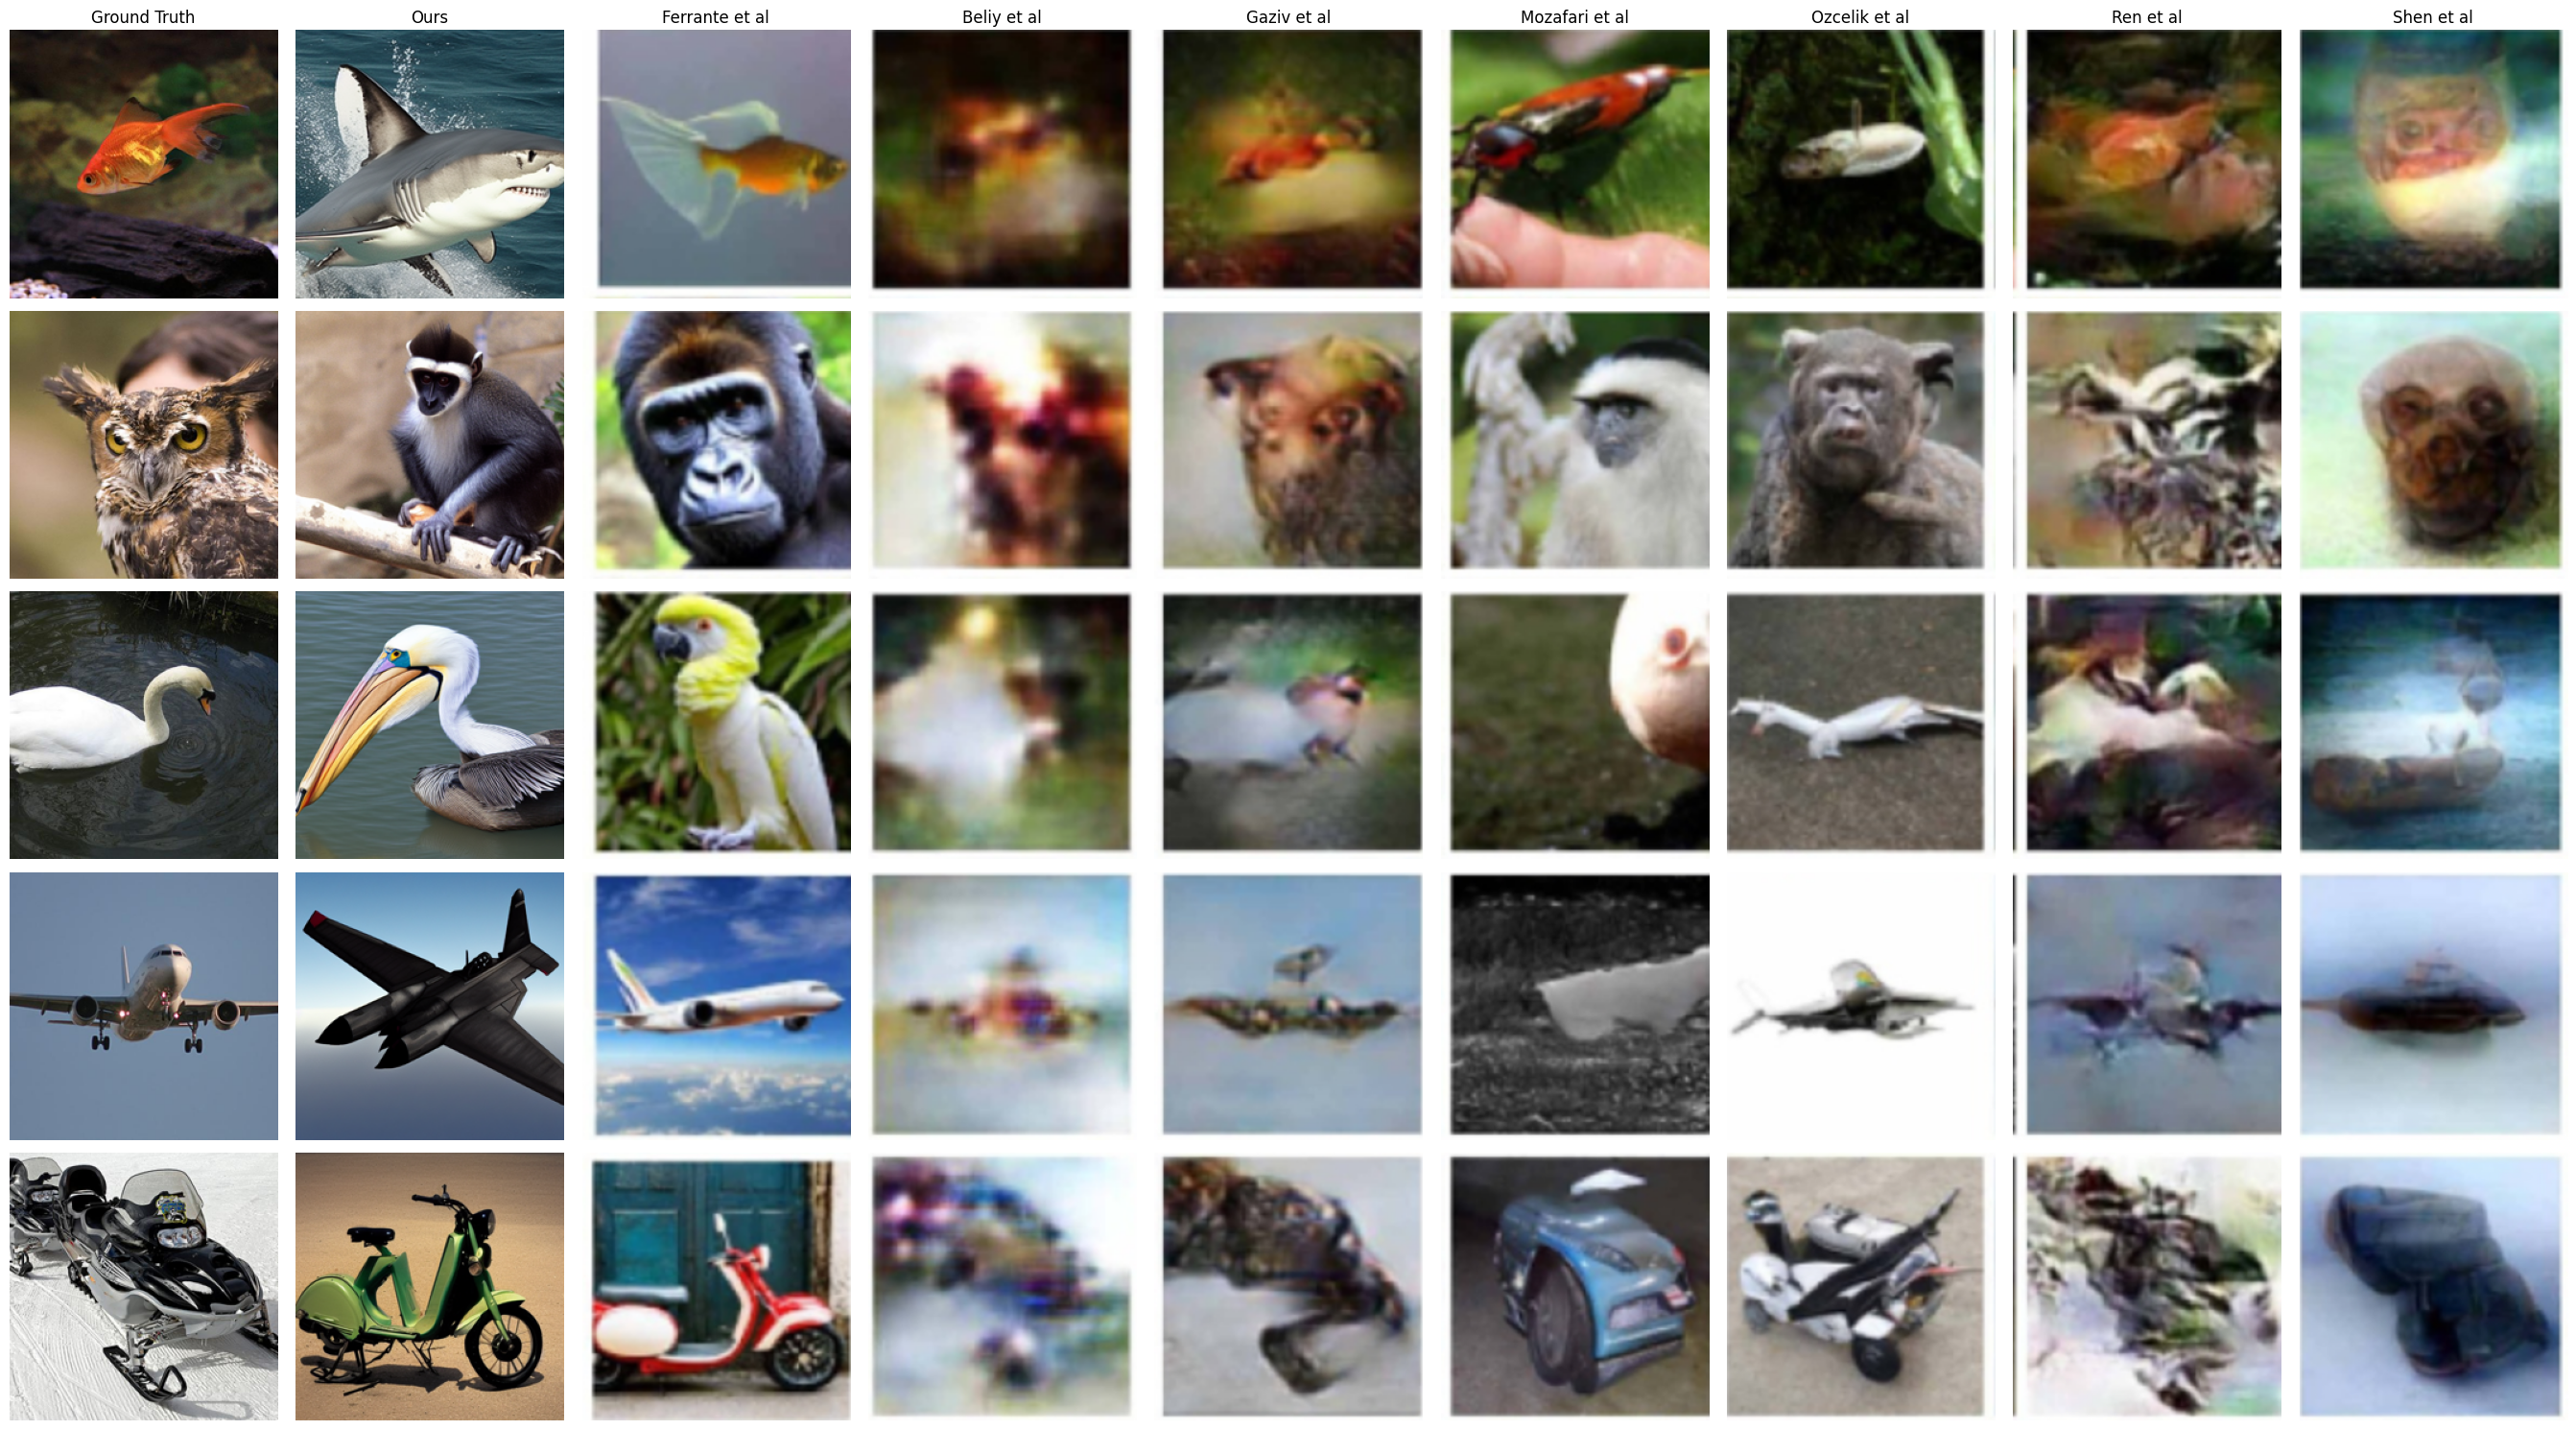

In [ ]:
n_rows = len(gt_files)
n_cols = len(studies) + 1  # GT + all studies

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

for i, fname in enumerate(gt_files):
    gt_img = load_image(os.path.join(gt_dir, fname))
    axs[i, 0].imshow(gt_img)
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title("Ground Truth")

    for j, study in enumerate(studies):
        study_path = os.path.join(base_dir, study)
        suffix = '_generated_clip.png' if study == 'Ours' else f'_{study.replace(" ", "_")}.png'
        rec_name = fname.replace('_ground_truth.png', suffix)
        rec_path = os.path.join(study_path, rec_name)

        if os.path.exists(rec_path):
            rec_img = load_image(rec_path)
            axs[i, j+1].imshow(rec_img)
        else:
            axs[i, j+1].imshow(np.ones((224, 224, 3)))
        axs[i, j+1].axis('off')
        if i == 0:
            axs[i, j+1].set_title(study)

plt.tight_layout()
plt.savefig("/content/Qualitative_Comparison.png")
plt.show()
